Modelo de predicción de RF para el par BTC/USD intervalo de 1d

# Importaciones

In [ ]:
#Installing Python modules
!pip install fastai==0.7.0
!pip install scikit-learn==0.21.3

#Data manipulation
import pandas as pd
import numpy as np
from time import time
import datetime

#Importing deep learning librery
from fastai.imports import *
from fastai.tabular import *

#Import packages
import math, re, IPython, graphviz

#Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from pprint import pprint

#Importing automatic learning packages
from sklearn import metrics , tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble._forest import RandomForestRegressor
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
from sklearn.model_selection import train_test_split , RandomizedSearchCV

from IPython.display import Image , display

  Using cached fastai-0.7.0-py3-none-any.whl (112 kB)
  Using cached bcolz-1.2.1.tar.gz (1.5 MB)
  Preparing metadata (setup.py) ... done
  Using cached feather-format-0.4.1.tar.gz (3.2 kB)
  Preparing metadata (setup.py) ... done
  Using cached isoweek-1.3.3-py2.py3-none-any.whl (7.1 kB)
  Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Using cached jupyter-1.0.0-py2.py3-none-any.whl (2.7 kB)
  Using cached pandas_summary-0.2.0-py2.py3-none-any.whl (5.2 kB)
  Using cached simplegeneric-0.8.1.zip (12 kB)
  Preparing metadata (setup.py) ... done
  Using cached testpath-0.6.0-py3-none-any.whl (83 kB)
INFO: pip is looking at multiple versions of fastai to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement torch<0.4 (from fastai) (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1)
ERROR: No matching distribution found for torch<0.

# Captura de datos (Con CSV)

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving BTC_day.csv to BTC_day (1).csv
User uploaded file "BTC_day (1).csv" with length 117411 bytes


In [ ]:
df = pd.read_csv("BTC_day.csv")
df.index = df['timestamp']
df['y']=df['close']

In [ ]:
df.drop(df.head(0).index,inplace=True)

In [ ]:
print(df.info())
print('\n')
print("Número de muestras:", df.shape[0])
print("Número de variables:", df.shape[1])

<class 'pandas.core.frame.DataFrame'>
Index: 1438 entries, 5/10/2016 to 4/16/2020
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  1438 non-null   object 
 1   open       1438 non-null   float64
 2   high       1438 non-null   float64
 3   low        1438 non-null   float64
 4   close      1438 non-null   float64
 5   Adj Close  1438 non-null   float64
 6   Volume     1438 non-null   int64  
 7   ignore     1438 non-null   int64  
 8   y          1438 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 112.3+ KB
None


Número de muestras: 1438
Número de variables: 9


In [ ]:
#df.shape
df.describe()
#df.count()
#df.tail()



,open,high,low,close,Adj Close,Volume,ignore,y
count,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1.438000e+03,1438.0,1438.000000
mean,5518.691137,5667.106320,5357.624534,5523.169674,5523.169674,9.134078e+09,0.0,5523.169674
std,3813.513361,3943.100105,3655.162510,3811.443958,3811.443958,1.117014e+10,0.0,3811.443958
min,437.792999,443.427002,437.389008,438.714996,438.714996,2.851400e+07,0.0,438.714996
25%,1503.257477,1583.280029,1500.617493,1542.115021,1542.115021,6.256185e+08,0.0,1542.115021
50%,5930.529297,6181.519532,5736.933106,5940.194824,5940.194824,4.792940e+09,0.0,5940.194824
75%,8224.231445,8369.572754,8008.121826,8221.173584,8221.173584,1.452341e+10,0.0,8221.173584
max,19475.800780,20089.000000,18974.099610,19497.400390,19497.400390,7.415677e+10,0.0,19497.400390


In [ ]:
df_small = df
features = ['open', 'high', 'low', 'close']

X_df = df_small[features]
y_df = df_small['y']

In [ ]:
# Correlaciones entre variables

df.drop([ 'ignore' ], axis='columns', inplace=True)
df.corr()

<ipython-input-44-b462c2fae50d>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,open,high,low,close,Adj Close,Volume,y
open,1.000000,0.998146,0.996915,0.996015,0.996015,0.595821,0.996015
high,0.998146,1.000000,0.996262,0.998311,0.998311,0.595995,0.998311
low,0.996915,0.996262,1.000000,0.997905,0.997905,0.597247,0.997905
close,0.996015,0.998311,0.997905,1.000000,1.000000,0.595922,1.000000
Adj Close,0.996015,0.998311,0.997905,1.000000,1.000000,0.595922,1.000000
Volume,0.595821,0.595995,0.597247,0.595922,0.595922,1.000000,0.595922
y,0.996015,0.998311,0.997905,1.000000,1.000000,0.595922,1.000000


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_df, y_df, test_size=0.09, random_state=42, shuffle=False)

In [ ]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_val.shape)
print('Testing Labels Shape:', y_val.shape)

Training Features Shape: (1308, 4)
Training Labels Shape: (1308,)
Testing Features Shape: (130, 4)
Testing Labels Shape: (130,)


In [ ]:
X_val

,open,high,low,close
timestamp,,,,
12/9/2019,7561.795410,7618.091797,7365.985352,7400.899414
12/10/2019,7397.134277,7424.022949,7246.043945,7278.119629
12/11/2019,7277.197754,7324.156250,7195.527344,7217.427246
12/12/2019,7216.738770,7266.639648,7164.741211,7243.134277
12/13/2019,7244.662109,7293.560547,7227.122559,7269.684570
...,...,...,...,...
4/12/2020,6858.067871,7119.947266,6811.078125,6971.091797
4/13/2020,6965.616699,6965.616699,6668.259766,6845.037598
4/14/2020,6843.281738,6958.557129,6793.821289,6842.427734


In [ ]:
X_train

,open,high,low,close
timestamp,,,,
5/10/2016,460.518005,461.928986,448.954010,450.894989
5/11/2016,450.864014,454.575989,450.864014,452.727997
5/12/2016,452.446991,454.949005,449.250000,454.765991
5/13/2016,454.850006,457.054993,453.453003,455.670013
5/14/2016,455.822998,456.835999,454.786011,455.670990
...,...,...,...,...
12/4/2019,7320.125000,7539.784668,7170.922852,7252.034668
12/5/2019,7253.241699,7743.431641,7232.676758,7448.307617
12/6/2019,7450.561523,7546.996582,7392.175293,7546.996582


In [ ]:
y_train

timestamp
5/10/2016     450.894989
5/11/2016     452.727997
5/12/2016     454.765991
5/13/2016     455.670013
5/14/2016     455.670990
                ...     
12/4/2019    7252.034668
12/5/2019    7448.307617
12/6/2019    7546.996582
12/7/2019    7556.237793
12/8/2019    7564.345215
Name: y, Length: 1308, dtype: float64

In [ ]:
y_val

timestamp
12/9/2019     7400.899414
12/10/2019    7278.119629
12/11/2019    7217.427246
12/12/2019    7243.134277
12/13/2019    7269.684570
                 ...     
4/12/2020     6971.091797
4/13/2020     6845.037598
4/14/2020     6842.427734
4/15/2020     6642.109863
4/16/2020     7116.804199
Name: y, Length: 130, dtype: float64

# OOB

OOB es el error de predicción media de cada muestra de la formación xᵢ , utilizando sólo los árboles que no tenían xᵢ en su muestra de arranque.

Se buscará una prueba del OOB error. Para ello, contaremos con todas las observaciones de forma desornedada y con un 1% de datos de validación, de tal forma que los datos más recientes pertenezcan al Set de entrenamiento.

In [ ]:
X_trainOOB, X_valOBB, y_trainOBB, y_valOBB = train_test_split(X_df, y_df, test_size=0.01, random_state=42, shuffle=True)

In [ ]:
OOB_model = RandomForestRegressor (n_estimators=10, bootstrap=True,  oob_score=True, random_state=42)
OOB_model.fit(X_trainOOB, y_trainOBB)
OOB_model.oob_score_

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


0.9572463033657771

In [ ]:
OOB_model = RandomForestRegressor (n_estimators=100, bootstrap=True,  oob_score=True, random_state=42)
OOB_model.fit(X_trainOOB, y_trainOBB)
OOB_model.oob_score_

0.9997994082113261

In [ ]:
OOB_model = RandomForestRegressor (n_estimators=300, bootstrap=True,  oob_score=True, random_state=42)
OOB_model.fit(X_trainOOB, y_trainOBB)
OOB_model.oob_score_

0.9998123906332509

In [ ]:
OOB_model = RandomForestRegressor (n_estimators=500, bootstrap=True,  oob_score=True, random_state=42)
OOB_model.fit(X_trainOOB, y_trainOBB)
OOB_model.oob_score_

0.9998117597400497

# Modelo por defecto

In [ ]:
#Functions to evaluate models (RMSE and R² of training and validation set)

def rmse(x,y): return math.sqrt(((x-y)**2).mean())
def print_score(m):
    res = [rmse(m.predict(X_train), y_train),
           rmse(m.predict(X_val), y_val),
                m.score(X_train, y_train),
                m.score(X_val, y_val)]
    print(f"RMSE training set: {res[0]} \nRMSE validation set: {res[1]} \nR² training set: {res[2]} \nR² validation set: {res[3]}")

In [ ]:
default_model = RandomForestRegressor(random_state=42)
default_model.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [ ]:
print_score(default_model)

RMSE training set: 21.117629238095795 
RMSE validation set: 13.412431753493196 
R² training set: 0.9999705753539246 
R² validation set: 0.999898241920804


# Modelo con árboles y mínimo de muestras en nodo modificado

In [ ]:
modified_trees_leaf_model = RandomForestRegressor(n_estimators=40, min_samples_leaf=25,  random_state=42)
modified_trees_leaf_model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=25, n_estimators=40, random_state=42)

In [ ]:
print_score(modified_trees_leaf_model)

RMSE training set: 295.4462383758275 
RMSE validation set: 71.14605296649685 
R² training set: 0.9942405918557947 
R² validation set: 0.9971367750294851


# Modelo con árboles y profundidad modificada

In [ ]:
modified_depth_model = RandomForestRegressor(n_estimators=30, max_depth=20,  random_state=42)
modified_depth_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=30, random_state=42)

In [ ]:
print_score(modified_depth_model)

RMSE training set: 21.83896769858794 
RMSE validation set: 14.074965673179168 
R² training set: 0.9999685308408895 
R² validation set: 0.9998879405364904


# Modelo con mayor número de árboles y misma profundidad

In [ ]:
modified_depth_and_trees_model = RandomForestRegressor(n_estimators=100, max_depth=14,  random_state=42)
modified_depth_and_trees_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=14, random_state=42)

In [ ]:
print_score(modified_depth_and_trees_model)

RMSE training set: 21.72757904905515 
RMSE validation set: 13.836055624430271 
R² training set: 0.9999688510362261 
R² validation set: 0.9998917124697113


# Errors modifying nº trees

In [ ]:
# Return MAE, MRSE, R²
def reg_acc(y_true, y_pre):
    return_var = []
    from math import sqrt
    rmse = sqrt(mean_squared_error(y_true,y_pre))
    return_var.append(rmse)
    print ("RMSE: ",rmse )
    r2 = r2_score(y_true,y_pre)
    return_var.append(r2)
    print ("R²: ",r2 )
    mae = mean_absolute_error(y_true,y_pre)
    return_var.append(mae)
    print ('MAE: ',mae)

    if 0 in y_true :
        print("MAPE can't be calculated")
        return_var.append(0)
    else :
        mape = round(np.mean(np.abs((y_true - y_pre)/y_true))*100,4)
        print ('MAPE :', mape)
        print('============================')
        print('Model Accuracy(%) :', 100-mape)
        print('============================')
        return_var.append(mape)
        return_var.append(100-mape)
    return return_var

In [ ]:
#Looking for the best nº estimators. Parameters by default

random_tree = [i*10 for i in range(1,50)]
rmse , r_sq , mae , mape = [],[],[],[]
for tree_size in random_tree:
    print('Tree Size:', tree_size)
    model = RandomForestRegressor(random_state=42, n_estimators=int(tree_size)).fit(X_train,y_train)
    model.fit(X_train, y_train)
    estimation = model.predict(X_val)
    result = reg_acc(y_val,estimation)
    rmse.append(result[0])
    r_sq.append(result[1])
    mae.append(result[2])
    mape.append(result[3])

Tree Size: 10
RMSE:  13.254751707910772
R²:  0.9999006204458877
MAE:  9.993895406923171
MAPE : 0.1323
Model Accuracy(%) : 99.8677
Tree Size: 20
RMSE:  18.051024592076804
R²:  0.99981568632183
MAE:  9.984907224230623
MAPE : 0.1377
Model Accuracy(%) : 99.8623
Tree Size: 30
RMSE:  14.074965673179168
R²:  0.9998879405364904
MAE:  8.600380597435707
MAPE : 0.1154
Model Accuracy(%) : 99.8846
Tree Size: 40
RMSE:  13.20476644865043
R²:  0.9999013685770248
MAE:  8.667835677884648
MAPE : 0.1152
Model Accuracy(%) : 99.8848
Tree Size: 50
RMSE:  12.585032699180868
R²:  0.9999104093790188
MAE:  8.545161439076933
MAPE : 0.1129
Model Accuracy(%) : 99.8871
Tree Size: 60
RMSE:  14.104358639962422
R²:  0.9998874720167981
MAE:  8.728161145256665
MAPE : 0.1162
Model Accuracy(%) : 99.8838
Tree Size: 70
RMSE:  13.72706777017344
R²:  0.9998934117318535
MAE:  8.523350334065912
MAPE : 0.1137
Model Accuracy(%) : 99.8863
Tree Size: 80
RMSE:  13.670538502857577
R²:  0.9998942878039078
MAE:  8.629906782692236
MAPE :

<Axes: title={'center': 'RMSE RATE'}, xlabel='Number of Trees', ylabel='RMSE'>

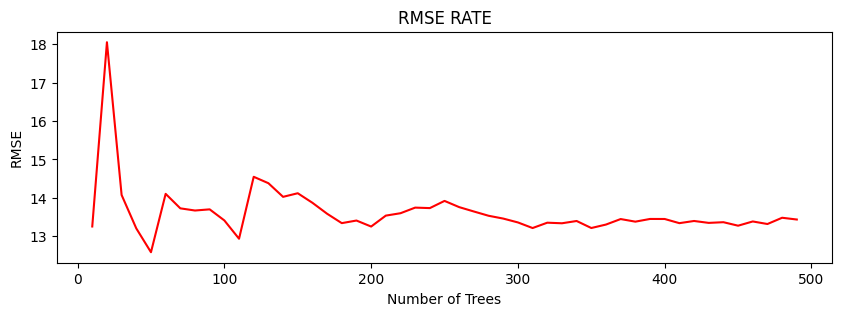

In [ ]:
plt.figure(figsize=(10,3))
plt.title('RMSE RATE')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
sns.lineplot(x=random_tree,y=rmse, color='red')

<Axes: title={'center': 'R² RATE'}, xlabel='Number of Trees', ylabel='R²'>

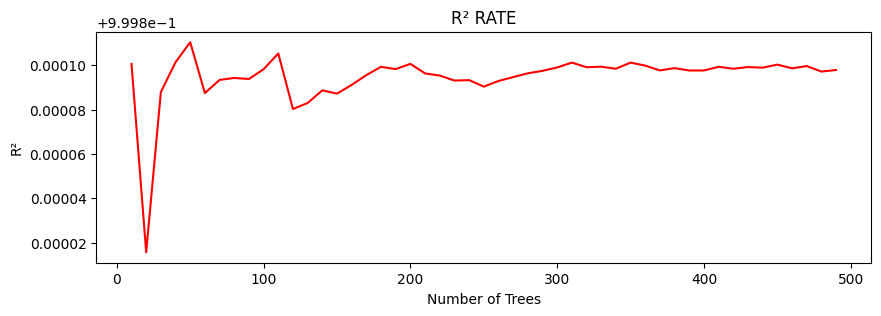

In [ ]:
plt.figure(figsize=(10,3))
plt.title('R² RATE')
plt.xlabel('Number of Trees')
plt.ylabel('R²')
sns.lineplot(x=random_tree,y=r_sq, color='red')

<Axes: title={'center': 'MAPE RATE'}, xlabel='Number of Trees', ylabel='MAPE'>

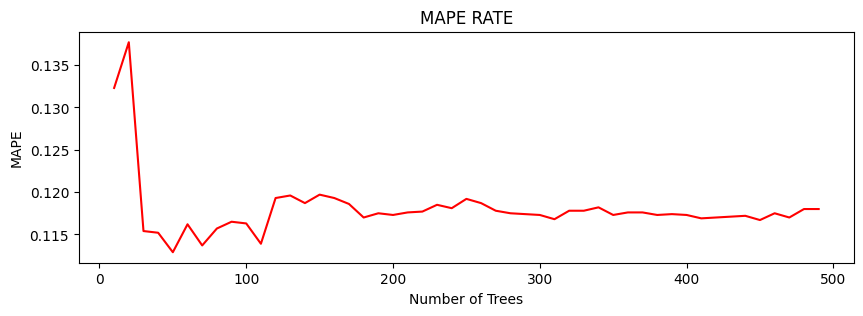

In [ ]:
plt.figure(figsize=(10,3))
plt.title('MAPE RATE')
plt.xlabel('Number of Trees')
plt.ylabel('MAPE')
sns.lineplot(x=random_tree,y=mape, color='red')

<Axes: title={'center': 'MAE RATE'}, xlabel='Number of Trees', ylabel='MAE'>

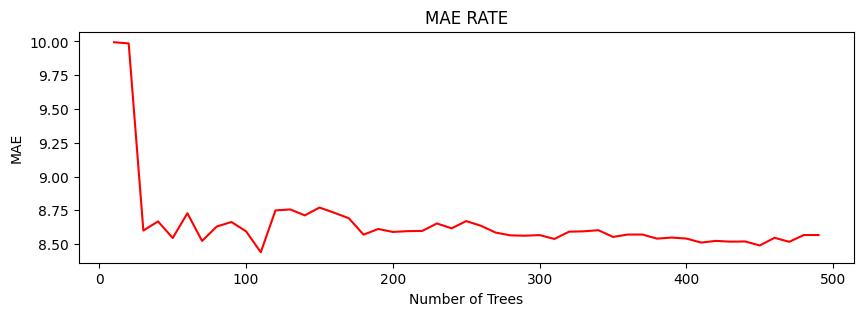

In [ ]:
plt.figure(figsize=(10,3))
plt.title('MAE RATE')
plt.xlabel('Number of Trees')
plt.ylabel('MAE')
sns.lineplot(x=random_tree,y=mae, color='red')

A priori, a partir de los 150 árboles los errores **RMSE, MAPE, MAE** son menores y alcanzan cierta estabilidad. Se plantea contruir el modelo con 150 árboles

# Errors modifying depth

In [ ]:
#Looking for the best nº estimators

random_depth = [i*2 for i in range(1,16)]
rmse , r_sq , mae , mape = [],[],[],[]
for depth_size in random_depth:
    print('Depth Size:', depth_size)
    model_depth = RandomForestRegressor(n_estimators=310,  random_state=42, max_depth=int(depth_size)).fit(X_train,y_train)
    model_depth.fit(X_train, y_train)
    estimation = model_depth.predict(X_val)
    result = reg_acc(y_val,estimation)
    rmse.append(result[0])
    r_sq.append(result[1])
    mae.append(result[2])
    mape.append(result[3])

Depth Size: 2
RMSE:  990.8577834276621
R²:  0.44463756478042615
MAE:  852.9172196530958
MAPE : 10.8244
Model Accuracy(%) : 89.1756
Depth Size: 4
RMSE:  159.20607225950948
R²:  0.9856625107122885
MAE:  134.46465894295656
MAPE : 1.759
Model Accuracy(%) : 98.241
Depth Size: 6
RMSE:  27.069584849878183
R²:  0.9995855071524034
MAE:  20.359494142507433
MAPE : 0.2751
Model Accuracy(%) : 99.7249
Depth Size: 8
RMSE:  14.319576460285813
R²:  0.9998840116966479
MAE:  10.150419040507355
MAPE : 0.1381
Model Accuracy(%) : 99.8619
Depth Size: 10
RMSE:  13.095949109929196
R²:  0.9999029874751313
MAE:  8.474036045215703
MAPE : 0.1161
Model Accuracy(%) : 99.8839
Depth Size: 12
RMSE:  13.10387509264562
R²:  0.9999028700109791
MAE:  8.409341304768818
MAPE : 0.1153
Model Accuracy(%) : 99.8847
Depth Size: 14
RMSE:  12.927882591334443
R²:  0.9999054615127325
MAE:  8.23386223927995
MAPE : 0.1127
Model Accuracy(%) : 99.8873
Depth Size: 16
RMSE:  13.215354889839233
R²:  0.999901210335417
MAE:  8.534872028238338

<Axes: title={'center': 'RMSE RATE'}, xlabel='Depth', ylabel='RMSE'>

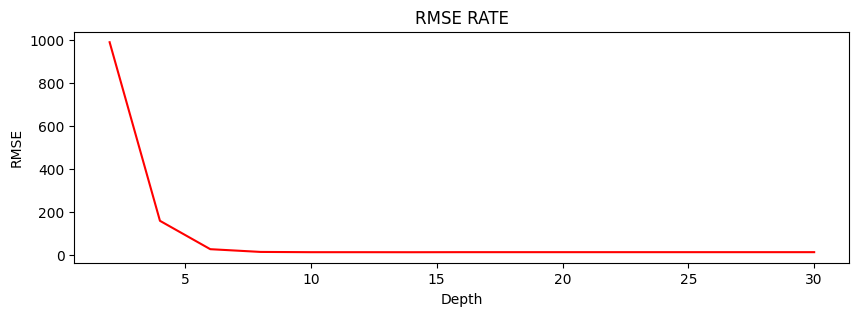

In [ ]:
plt.figure(figsize=(10,3))
plt.title('RMSE RATE')
plt.xlabel('Depth')
plt.ylabel('RMSE')
sns.lineplot(x=random_depth,y=rmse, color='red')

<Axes: title={'center': 'R² RATE'}, xlabel='Depth', ylabel='R²'>

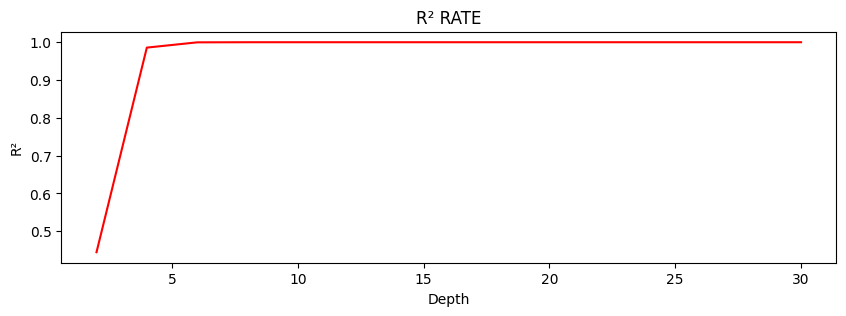

In [ ]:
plt.figure(figsize=(10,3))
plt.title('R² RATE')
plt.xlabel('Depth')
plt.ylabel('R²')
sns.lineplot(x=random_depth,y=r_sq, color='red')

<Axes: title={'center': 'MAPE RATE'}, xlabel='Depth', ylabel='MAPE'>

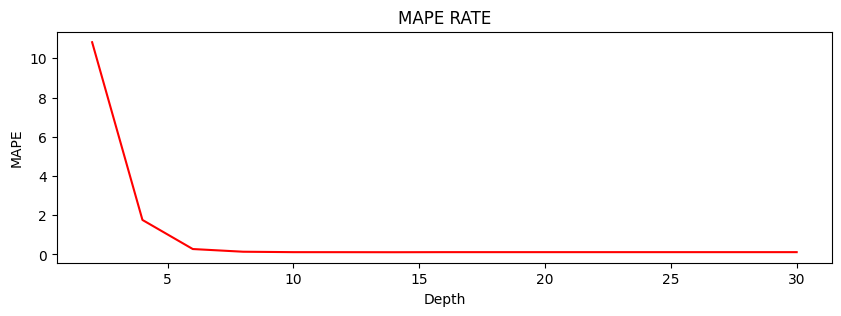

In [ ]:
plt.figure(figsize=(10,3))
plt.title('MAPE RATE')
plt.xlabel('Depth')
plt.ylabel('MAPE')
sns.lineplot(x=random_depth,y=mape, color='red')

<Axes: title={'center': 'MAE RATE'}, xlabel='Depth', ylabel='MAE'>

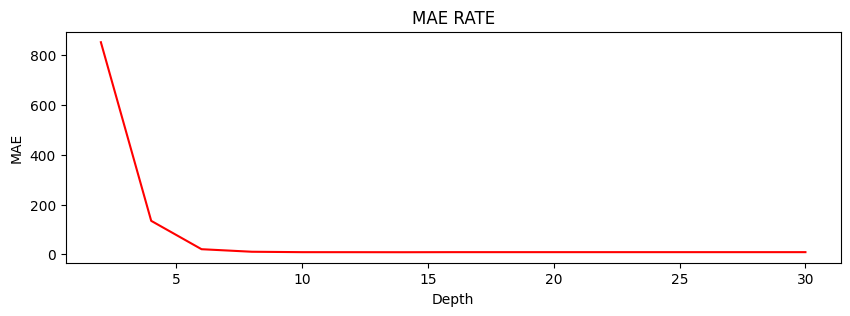

In [ ]:
plt.figure(figsize=(10,3))
plt.title('MAE RATE')
plt.xlabel('Depth')
plt.ylabel('MAE')
sns.lineplot(x=random_depth,y=mae, color='red')

A priori, a partir de una profundidad de 6 los errores RMSE, MAPE, MAE son menores y alcanzan cierta estabilidad. Se plantea contruir el modelo con 150 árboles y profundidad 6.

# Modelo con 310 árboles y profundidad 14 (en base a los resultados)


In [ ]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())
def print_score(m):
    res = [rmse(m.predict(X_train), y_train),
           rmse(m.predict(X_val), y_val),
                m.score(X_train, y_train),
                m.score(X_val, y_val)]
    print(f"RMSE training set: {res[0]} \nRMSE validation set: {res[1]} \nR² training set: {res[2]} \nR² validation set: {res[3]}")

In [ ]:
modified_final = RandomForestRegressor(n_estimators=310, max_depth=14, random_state=42)
modified_final.fit(X_train, y_train)

print_score(modified_final)

RMSE training set: 19.973999133704773 
RMSE validation set: 12.927882591334443 
R² training set: 0.9999736760546947 
R² validation set: 0.9999054615127325


# Random Search with Cross Validation

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 50, num = 45)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6, 8, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8, 10, 12, 14, 16, 20, 25, 30]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, None], 'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12, 14, 16, 20, 25, 30], 'bootstrap': [True]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, scoring='neg_mean_squared_error',
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=False)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [5, 6, 7, 8, 9, 10, 11, 12,
                                                      13, 14, 15, 16, 17, 18,
                                                      19, 20, 21, 22, 23, 24,
                                                      25, 26, 27, 28, 29, 30,
                                                      31, 32, 33, 34, ...],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8, 10,
                                                             12, 14, 16, 20, 25,
                                                             30],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200, 210, 220, 230,
                                                         240, 250, 260, 270,
                                                         280, 290, 300, ...]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [ ]:
rf_random.best_params_

{'n_estimators': 240,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 34,
 'bootstrap': True}

**Evaluate the Best Random Search Model**

In [ ]:
best_random = rf_random.best_estimator_

rmse , r_sq , mae , mape = [],[],[],[]
print('Model Performance\n')
print('Tree Size:', best_random.n_estimators)
estimation = best_random.predict(X_val)
result_best = reg_acc(y_val,estimation)
rmse.append(result_best[0])
r_sq.append(result_best[1])
mae.append(result_best[2])
mape.append(result_best[3])

Model Performance

Tree Size: 240
RMSE:  13.815443491003053
R²:  0.9998920348700406
MAE:  8.909901617874773
MAPE : 0.1227
Model Accuracy(%) : 99.8773


#Grid Search
We will perform grid search building on the result from the random search. We will test a range of hyperparameters around the best values returned by random search.

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [20,25,30],
    'max_features': ['auto'],
    'min_samples_leaf': [2,4,6],
    'min_samples_split': [6,8,9],
    'n_estimators': [220,260,310]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=False, scoring='neg_mean_squared_error')

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train);


Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [ ]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 220}

In [ ]:
best_grid = grid_search.best_estimator_

rmse , r_sq , mae , mape = [],[],[],[]
print('Model Performance\n')
print('Tree Size:', best_grid.n_estimators)
estimation = best_grid.predict(X_val)
result_best_grid = reg_acc(y_val,estimation)
rmse.append(result_best_grid[0])
r_sq.append(result_best_grid[1])
mae.append(result_best_grid[2])
mape.append(result_best_grid[3])

Model Performance

Tree Size: 220
RMSE:  13.831765664426353
R²:  0.9998917796098223
MAE:  9.186012085278952
MAPE : 0.1265
Model Accuracy(%) : 99.8735


#Another Round of Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [14,16,18],
    'max_features': ['auto','sqrt'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2,4,6],
    'n_estimators': [240,270,320]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search_final = GridSearchCV(estimator = rf, param_grid = param_grid,
                                 cv = 3, n_jobs = -1, verbose = 2,scoring='neg_mean_squared_error', return_train_score=False)

grid_search_final.fit(X_train, y_train);

Fitting 3 folds for each of 162 candidates, totalling 486 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [ ]:
grid_search_final.best_params_

{'bootstrap': True,
 'max_depth': 14,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 240}

In [ ]:
best_grid_final = grid_search_final.best_estimator_

rmse , r_sq , mae , mape = [],[],[],[]
print('Model Performance\n')
print('Tree Size:', best_grid_final.n_estimators)
estimation = best_grid_final.predict(X_val)
result_best_grid_final = reg_acc(y_val,estimation)
rmse.append(result_best_grid_final[0])
r_sq.append(result_best_grid_final[1])
mae.append(result_best_grid_final[2])
mape.append(result_best_grid_final[3])

Model Performance

Tree Size: 240
RMSE:  13.462939739642382
R²:  0.9998974740849651
MAE:  8.301685501633864
MAPE : 0.1138
Model Accuracy(%) : 99.8862


A very slight improvement in accuracy means we have reached the point of diminishing returns from tuning. We will stop here and use this as our final model.

#Final Model

In [ ]:
final_model = modified_final

print('Final Model Parameters:\n')
pprint(final_model.get_params())
print('\n')

rmse , r_sq , mae , mape = [],[],[],[]
print('Model Performance\n')
print('Tree Size:', final_model.n_estimators)
estimation = final_model.predict(X_val)
result_final_model = reg_acc(y_val,estimation)
rmse.append(result_final_model[0])
r_sq.append(result_final_model[1])
mae.append(result_final_model[2])
mape.append(result_final_model[3])


Final Model Parameters:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 14,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 310,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Model Performance

Tree Size: 310
RMSE:  12.927882591334443
R²:  0.9999054615127325
MAE:  8.23386223927995
MAPE : 0.1127
Model Accuracy(%) : 99.8873


#Comparison of All Improvement Techniques

In [ ]:
# Time used for evaluating model run times
import time

In [ ]:
# Evaluate run time and prediction accuracy
def evaluate_model(model, X_train, y_train, X_val, y_val):
    n_trees = model.get_params()['n_estimators']
    max_depth = model.get_params()['max_depth']
    min_samples_leaf = model.get_params()['min_samples_leaf']
    min_samples_split = model.get_params()['min_samples_split']

    n_features = X_train.shape[1]

    # Train and predict 10 times to evaluate time and accuracy
    predictions = []
    run_times = []
    for _ in range(10):
        start_time = time.time()
        model.fit(X_train, y_train)
        predictions.append(model.predict(X_val))

        end_time = time.time()
        run_times.append(end_time - start_time)

    # Run time and predictions need to be averaged
    run_time = np.mean(run_times)
    predictions = np.mean(np.array(predictions), axis = 0)

    # Calculate performance metrics
    rmse , r_sq , mae , mape = [],[],[],[]
    estimation = model.predict(X_val)
    result = reg_acc(y_val,estimation)
    rmse.append(result[0])
    r_sq.append(result[1])
    mae.append(result[2])
    mape.append(result[3])

    # Return results in a dictionary
    results = {'time': run_time, 'RMSE': result[0],'R²': result[1],'MAE': result[2],
               'MAPE': result[3], 'accuracy': 100-result[3], 'n_trees': n_trees, 'n_features': n_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

    return results

**Random Search Best Model**

In [ ]:
random_results = evaluate_model(best_random, X_train, y_train, X_val, y_val)
random_results['model'] = 'best_random'

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

RMSE:  13.815443491003053
R²:  0.9998920348700406
MAE:  8.909901617874773
MAPE : 0.1227
Model Accuracy(%) : 99.8773


**First Grid Search Best Model**

In [ ]:
first_grid_results = evaluate_model(best_grid, X_train, y_train, X_val, y_val)
first_grid_results['model'] = 'first_grid'

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

RMSE:  13.831765664426353
R²:  0.9998917796098223
MAE:  9.186012085278952
MAPE : 0.1265
Model Accuracy(%) : 99.8735


**Second Grid Search Best Model**

In [ ]:
final_model_results = evaluate_model(best_grid_final, X_train, y_train, X_val, y_val)
final_model_results['model'] = 'second_grid'

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

RMSE:  13.462939739642382
R²:  0.9998974740849651
MAE:  8.301685501633864
MAPE : 0.1138
Model Accuracy(%) : 99.8862


**Primer modelo planteado de RF**

In [ ]:
default_model_results = evaluate_model(default_model, X_train, y_train, X_val, y_val)
default_model_results['model'] = 'default_model'

RMSE:  13.412431753493196
R²:  0.999898241920804
MAE:  8.594227148922354
MAPE : 0.1163
Model Accuracy(%) : 99.8837


**Segundo modelo: modificado nº árboles y min_samples_leaf**

In [ ]:
modified_trees_leaf_model_results = evaluate_model(modified_trees_leaf_model, X_train, y_train, X_val, y_val)
modified_trees_leaf_model_results['model'] = 'modified_trees_leaf_model'

RMSE:  71.14605296649685
R²:  0.9971367750294851
MAE:  53.92236503139285
MAPE : 0.7333
Model Accuracy(%) : 99.2667


**Tercer modelo: cambio de profundidad**

In [ ]:
modified_depth_model_results = evaluate_model(modified_depth_model, X_train, y_train, X_val, y_val)
modified_depth_model_results['model'] = 'modified_depth_model'

RMSE:  14.074965673179168
R²:  0.9998879405364904
MAE:  8.600380597435707
MAPE : 0.1154
Model Accuracy(%) : 99.8846


**Cuarto modelo: cambio de profundidad y nº árboles**

In [ ]:
modified_depth_and_trees_model_results = evaluate_model(modified_depth_and_trees_model, X_train, y_train, X_val, y_val)
modified_depth_and_trees_model_results['model'] = 'modified_depth_and_trees_model'

RMSE:  13.836055624430271
R²:  0.9998917124697113
MAE:  8.64370218030739
MAPE : 0.1186
Model Accuracy(%) : 99.8814


**Quinto modelo: Modelo final tras modificaciones manuales**

In [ ]:
modified_final_results = evaluate_model(modified_final, X_train, y_train, X_val, y_val)
modified_final_results['model'] = 'modified_final'

RMSE:  12.927882591334443
R²:  0.9999054615127325
MAE:  8.23386223927995
MAPE : 0.1127
Model Accuracy(%) : 99.8873


**Comparison**

In [ ]:
comparison = {'model' : [default_model_results['model'], modified_trees_leaf_model_results['model'], modified_depth_model_results['model'], modified_depth_and_trees_model_results['model'], modified_final_results['model'], random_results['model'], first_grid_results['model'], final_model_results['model']],
           'n_features' : [default_model_results['n_features'], modified_trees_leaf_model_results['n_features'], modified_depth_model_results['n_features'], modified_depth_and_trees_model_results['n_features'], modified_final_results['n_features'], random_results['n_features'], first_grid_results['n_features'], final_model_results['n_features']],
           'n_trees' : [default_model_results['n_trees'], modified_trees_leaf_model_results['n_trees'], modified_depth_model_results['n_trees'], modified_depth_and_trees_model_results['n_trees'], modified_final_results['n_trees'], random_results['n_trees'], first_grid_results['n_trees'], final_model_results['n_trees']],
           'max_depth' : [default_model_results['max_depth'], modified_trees_leaf_model_results['max_depth'], modified_depth_model_results['max_depth'], modified_depth_and_trees_model_results['max_depth'], modified_final_results['max_depth'], random_results['max_depth'], first_grid_results['max_depth'], final_model_results['max_depth']],
           'min_samples_leaf' : [default_model_results['min_samples_leaf'], modified_trees_leaf_model_results['min_samples_leaf'], modified_depth_model_results['min_samples_leaf'], modified_depth_and_trees_model_results['min_samples_leaf'], modified_final_results['min_samples_leaf'], random_results['min_samples_leaf'], first_grid_results['min_samples_leaf'], final_model_results['min_samples_leaf']],
           'min_samples_split' : [default_model_results['min_samples_split'], modified_trees_leaf_model_results['min_samples_split'], modified_depth_model_results['min_samples_split'], modified_depth_and_trees_model_results['min_samples_split'], modified_final_results['min_samples_split'], random_results['min_samples_split'], first_grid_results['min_samples_split'], final_model_results['min_samples_split']],
           'RMSE' : [default_model_results['RMSE'], modified_trees_leaf_model_results['RMSE'], modified_depth_model_results['RMSE'], modified_depth_and_trees_model_results['RMSE'], modified_final_results['RMSE'], random_results['RMSE'], first_grid_results['RMSE'], final_model_results['RMSE']],
           'R²' : [default_model_results['R²'], modified_trees_leaf_model_results['R²'], modified_depth_model_results['R²'], modified_depth_and_trees_model_results['R²'], modified_final_results['R²'], random_results['R²'], first_grid_results['R²'], final_model_results['R²']],
           'MAE' : [default_model_results['MAE'], modified_trees_leaf_model_results['MAE'], modified_depth_model_results['MAE'], modified_depth_and_trees_model_results['MAE'], modified_final_results['MAE'], random_results['MAE'], first_grid_results['MAE'], final_model_results['MAE']],
           'MAPE' : [default_model_results['MAPE'], modified_trees_leaf_model_results['MAPE'], modified_depth_model_results['MAPE'], modified_depth_and_trees_model_results['MAPE'], modified_final_results['MAPE'], random_results['MAPE'], first_grid_results['MAPE'], final_model_results['MAPE']],
           'accuracy' : [default_model_results['accuracy'], modified_trees_leaf_model_results['accuracy'], modified_depth_model_results['accuracy'], modified_depth_and_trees_model_results['accuracy'], modified_final_results['accuracy'], random_results['accuracy'], first_grid_results['accuracy'], final_model_results['accuracy']],
           'time' : [default_model_results['time'], modified_trees_leaf_model_results['time'], modified_depth_model_results['time'], modified_depth_and_trees_model_results['time'], modified_final_results['time'], random_results['time'], first_grid_results['time'], final_model_results['time']]}


comparison = pd.DataFrame(comparison, columns = ['model', 'n_features', 'n_trees','max_depth','min_samples_leaf','min_samples_split','RMSE','R²','MAE','MAPE','accuracy','time'])
comparison



,model,n_features,n_trees,max_depth,min_samples_leaf,min_samples_split,RMSE,R²,MAE,MAPE,accuracy,time
0,default_model,4,100,NaN,1,2,13.412432,0.999898,8.594227,0.1163,99.8837,0.428689
1,modified_trees_leaf_model,4,40,NaN,25,2,71.146053,0.997137,53.922365,0.7333,99.2667,0.096395
2,modified_depth_model,4,30,20.0,1,2,14.074966,0.999888,8.600381,0.1154,99.8846,0.122811
3,modified_depth_and_trees_model,4,100,14.0,1,2,13.836056,0.999892,8.643702,0.1186,99.8814,0.386654
4,modified_final,4,310,14.0,1,2,12.927883,0.999905,8.233862,0.1127,99.8873,1.278814
5,best_random,4,240,34.0,1,4,13.815443,0.999892,8.909902,0.1227,99.8773,0.940008
6,first_grid,4,220,20.0,2,6,13.831766,0.999892,9.186012,0.1265,99.8735,0.888270
7,second_grid,4,240,14.0,1,2,13.462940,0.999897,8.301686,0.1138,99.8862,1.020944


# Plotting

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('fivethirtyeight')

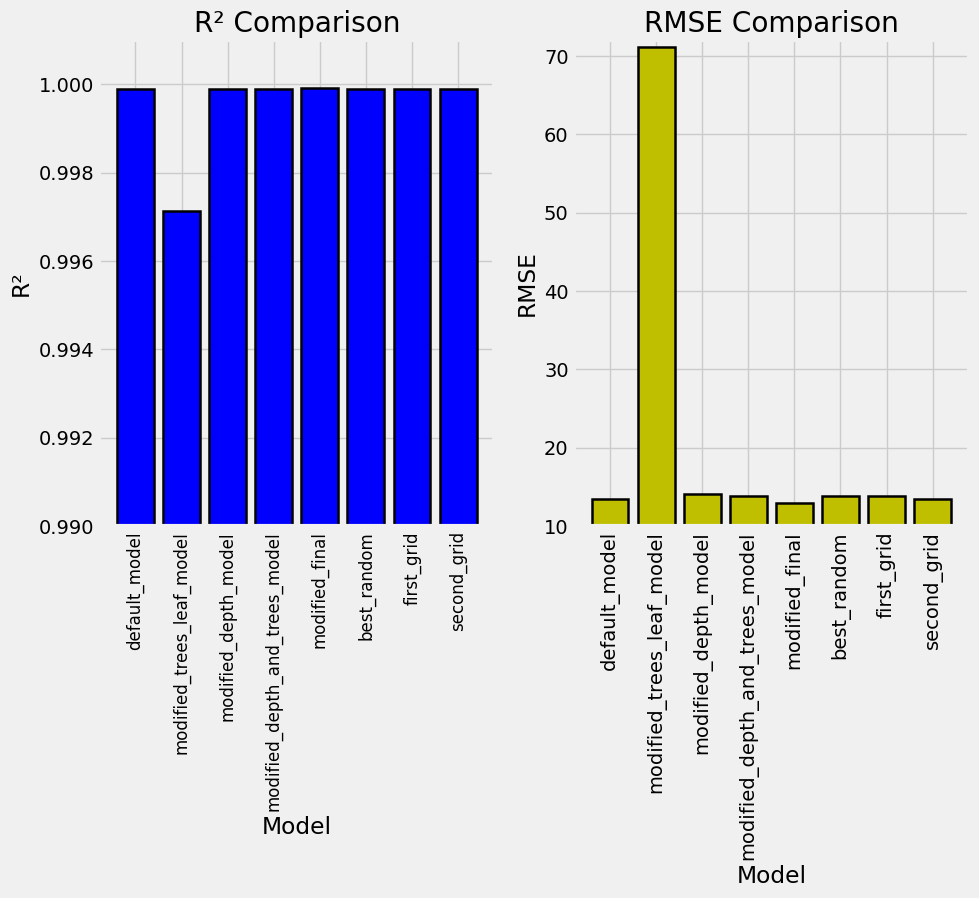

In [ ]:
xvalues = list(range(len(comparison)))
plt.subplots(1, 2, figsize=(10, 6))
plt.subplot(121)
plt.bar(xvalues, comparison['R²'], color = 'b', edgecolor = 'k', linewidth = 1.8)
plt.xticks(xvalues, comparison['model'], rotation = 90, fontsize = 12)
plt.ylim(ymin = 0.99, ymax = 1.001)
plt.xlabel('Model'); plt.ylabel('R²'); plt.title('R² Comparison');

plt.subplot(122)
plt.bar(xvalues, comparison['RMSE'], color = 'y', edgecolor = 'k', linewidth = 1.8)
plt.xticks(xvalues, comparison['model'], rotation = 90)
plt.ylim(ymin = 10, ymax = 72)
plt.xlabel('Model'); plt.ylabel('RMSE'); plt.title('RMSE Comparison');

plt.show();

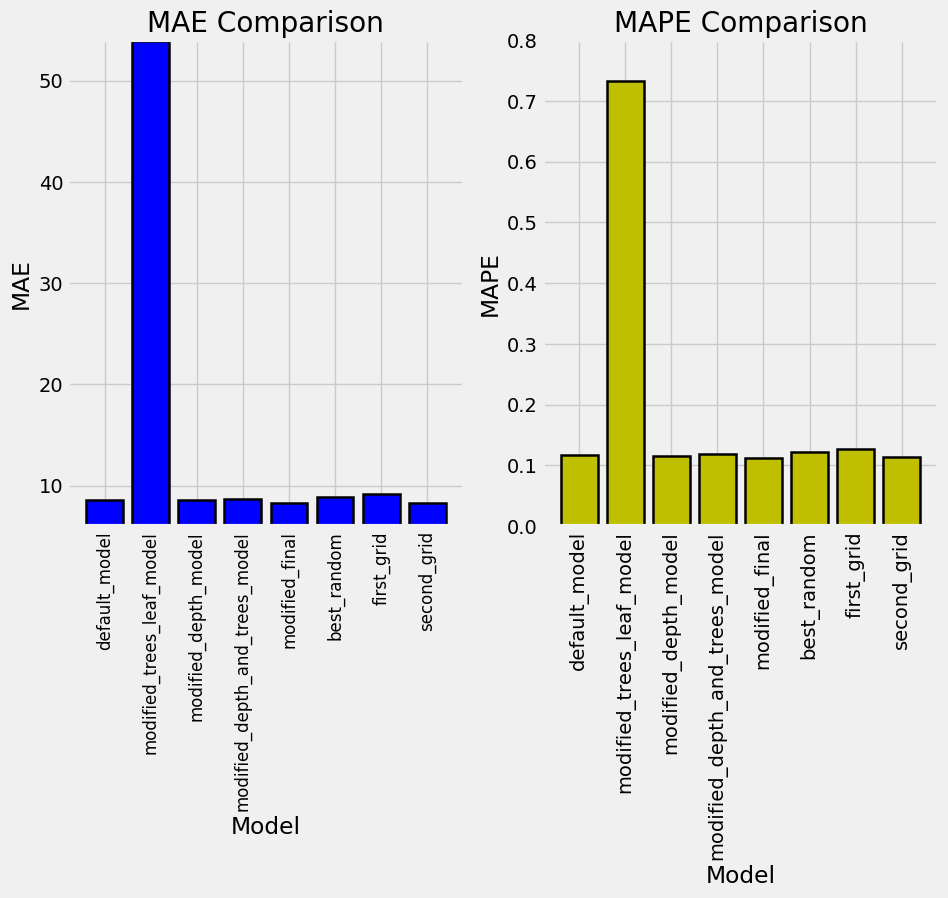

In [ ]:
xvalues = list(range(len(comparison)))
plt.subplots(1, 2, figsize=(10, 6))
plt.subplot(121)
plt.bar(xvalues, comparison['MAE'], color = 'b', edgecolor = 'k', linewidth = 1.8)
plt.xticks(xvalues, comparison['model'], rotation = 90, fontsize = 12)
plt.ylim(ymin = 6, ymax = 54)
plt.xlabel('Model'); plt.ylabel('MAE'); plt.title('MAE Comparison');

plt.subplot(122)
plt.bar(xvalues, comparison['MAPE'], color = 'y', edgecolor = 'k', linewidth = 1.8)
plt.xticks(xvalues, comparison['model'], rotation = 90)
plt.ylim(ymin = 0, ymax = 0.8)
plt.xlabel('Model'); plt.ylabel('MAPE'); plt.title('MAPE Comparison');

plt.show();

# Gráfica valores reales vs predichos

In [ ]:
preds = np.stack([t.predict(X_val) for t in final_model.estimators_])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without featu

In [ ]:
#Comparing our model’s results against the validation set, here is the row of predictions, the mean of the predictions
#and the actual value from validation set.

print("0th Row for prediction from all trees:")
print(preds[:,0])
print("\nMean of the predictions:")
print(np.mean(preds[:,0]) )
print("\nActual value:")
print(y_val[0])

0th Row for prediction from all trees:
[7397.796875 7397.796875 7418.490234 7406.52002  7355.879883 7406.52002
 7397.796875 7397.796875 7406.52002  7406.52002  7407.410156 7407.410156
 7434.390137 7406.52002  7418.490234 7407.410156 7397.796875 7406.52002
 7407.410156 7407.410156 7418.490234 7434.390137 7407.410156 7406.52002
 7397.796875 7434.390137 7407.410156 7407.410156 7406.52002  7418.490234
 7355.879883 7407.410156 7407.410156 7407.410156 7397.796875 7370.779785
 7397.796875 7406.52002  7355.879883 7406.52002  7406.52002  7397.796875
 7407.410156 7406.52002  7406.52002  7397.796875 7397.796875 7397.796875
 7397.796875 7407.410156 7424.29248  7406.52002  7407.410156 7418.490234
 7406.52002  7434.390137 7406.52002  7434.390137 7406.52002  7434.390137
 7397.796875 7406.52002  7397.796875 7407.410156 7406.52002  7355.879883
 7434.390137 7397.796875 7406.52002  7368.220215 7406.52002  7397.796875
 7424.29248  7407.410156 7424.29248  7397.796875 7368.220215 7424.29248
 7397.796875 740

In [ ]:
rf_test_pred_final = final_model.predict(X_val)
rf_prediction_values = pd.DataFrame({'Precio de Cierre Real':y_val,'Precio de Cierre Previsto':rf_test_pred_final})
rf_prediction_values.head(10)

,Precio de Cierre Real,Precio de Cierre Previsto
timestamp,,
12/9/2019,7400.899414,7406.173814
12/10/2019,7278.119629,7270.896503
12/11/2019,7217.427246,7219.364798
12/12/2019,7243.134277,7256.376328
12/13/2019,7269.684570,7269.260276
12/14/2019,7124.673828,7141.620256
12/15/2019,7152.301758,7144.329029
12/16/2019,6932.480469,6948.102423
12/17/2019,6640.515137,6641.210854


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 [Text(-20.0, 0, '3/28/2020'),
  Text(0.0, 0, '12/9/2019'),
  Text(20.0, 0, '12/29/2019'),
  Text(40.0, 0, '1/18/2020'),
  Text(60.0, 0, '2/7/2020'),
  Text(80.0, 0, '2/27/2020'),
  Text(100.0, 0, '3/18/2020'),
  Text(120.0, 0, '4/7/2020'),
  Text(140.0, 0, '')])

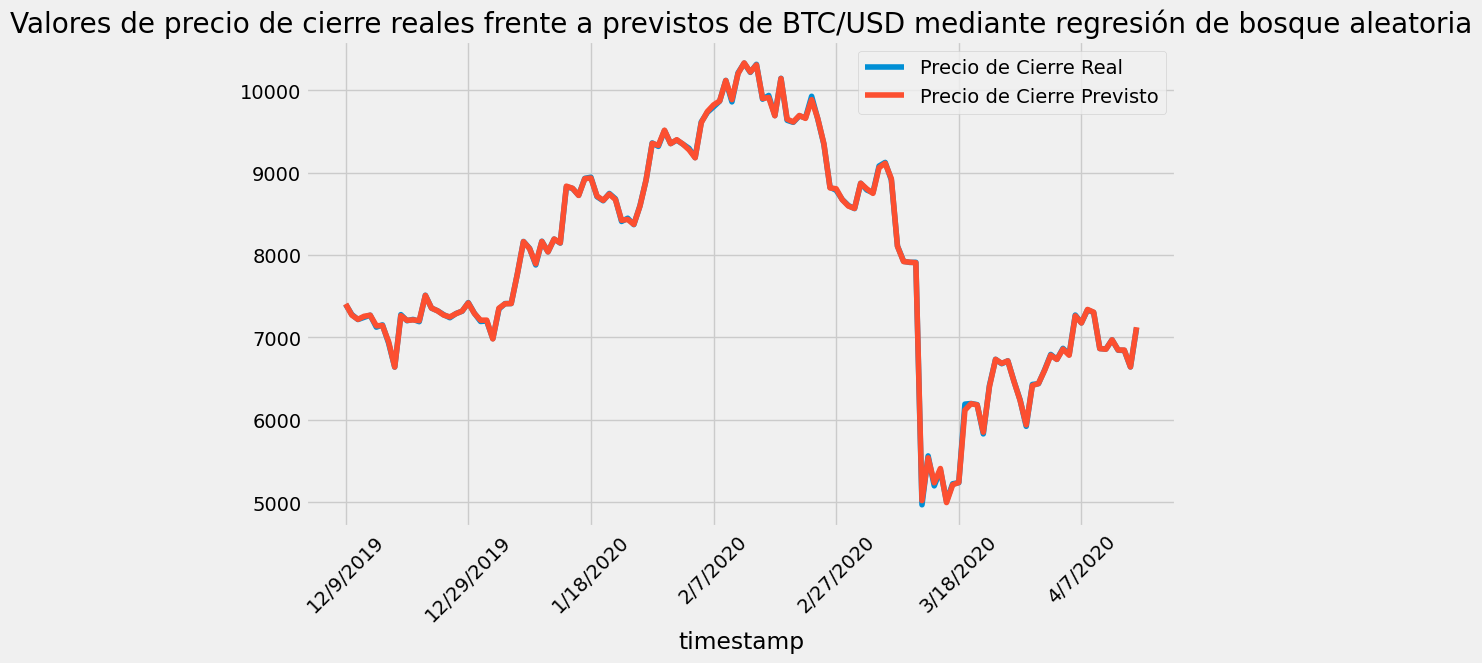

In [ ]:
rf_prediction_values[['Precio de Cierre Real','Precio de Cierre Previsto']].plot(figsize = (10,6))
plt.title('Valores de precio de cierre reales frente a previstos de BTC/USD mediante regresión de bosque aleatoria')
plt.xticks(rotation=45)

(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 [Text(-2.5, 0, ''),
  Text(0.0, 0, '12/9/2019'),
  Text(2.5, 0, ''),
  Text(5.0, 0, '12/14/2019'),
  Text(7.5, 0, ''),
  Text(10.0, 0, '12/19/2019'),
  Text(12.5, 0, ''),
  Text(15.0, 0, '12/24/2019'),
  Text(17.5, 0, ''),
  Text(20.0, 0, '')])

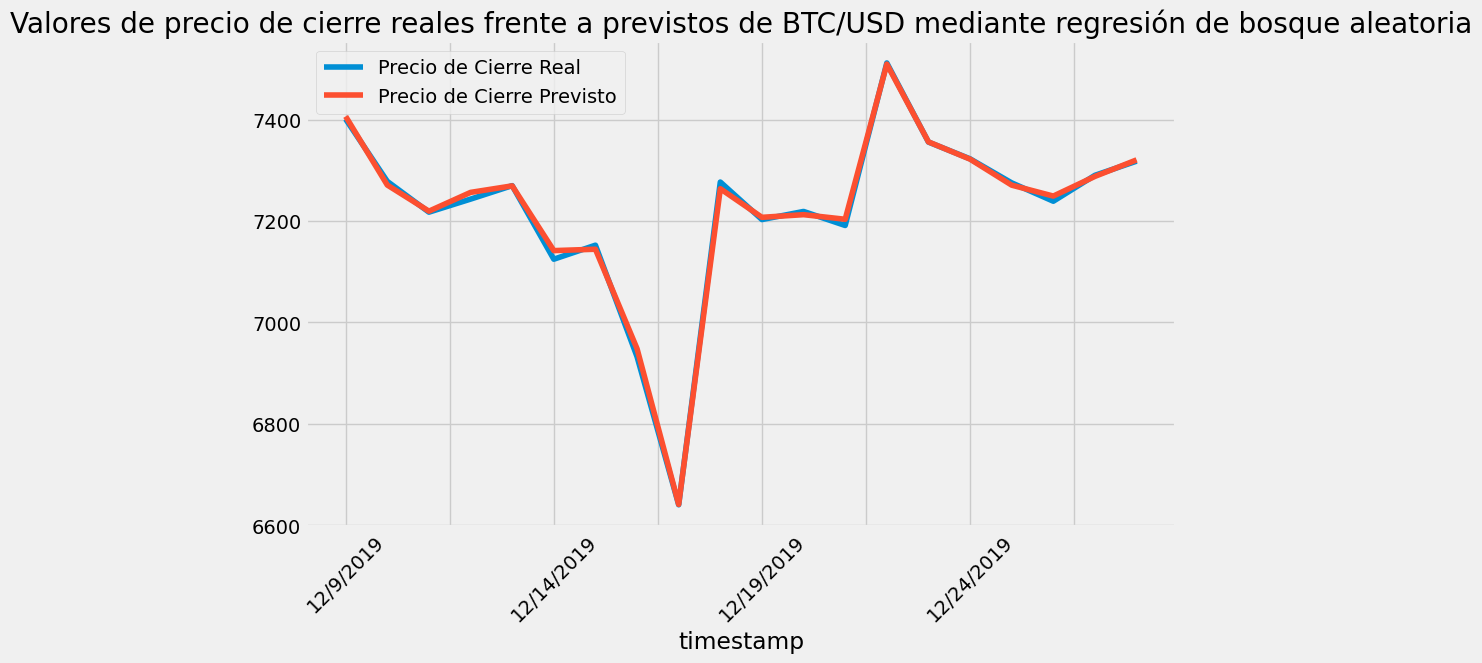

In [ ]:
rf_prediction_values.head(20)[['Precio de Cierre Real','Precio de Cierre Previsto']].plot(figsize = (10,6))
plt.title('Valores de precio de cierre reales frente a previstos de BTC/USD mediante regresión de bosque aleatoria')
plt.xticks(rotation=45)

# Importancia de las variables

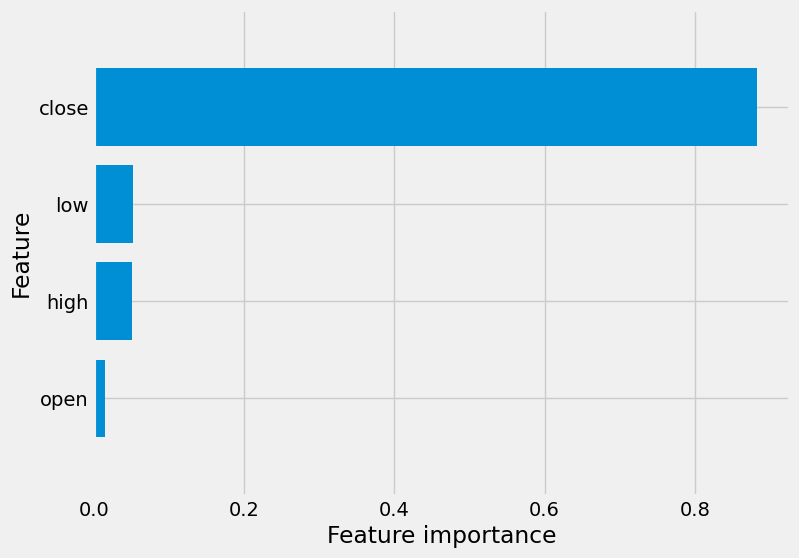

In [ ]:
def plot_feature_importances_features(final_model):
    plt.figure(figsize=(8,6))
    n_features = 4
    plt.barh(range(n_features), final_model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
plot_feature_importances_features(final_model)
plt.savefig('feature_importance')

In [ ]:
for feature in zip(features, final_model.feature_importances_):
    print(feature)

('open', 0.014923022453376863)
('high', 0.051158911997012946)
('low', 0.05159860794327632)
('close', 0.8823194576063339)


# Representación de árboles de RF



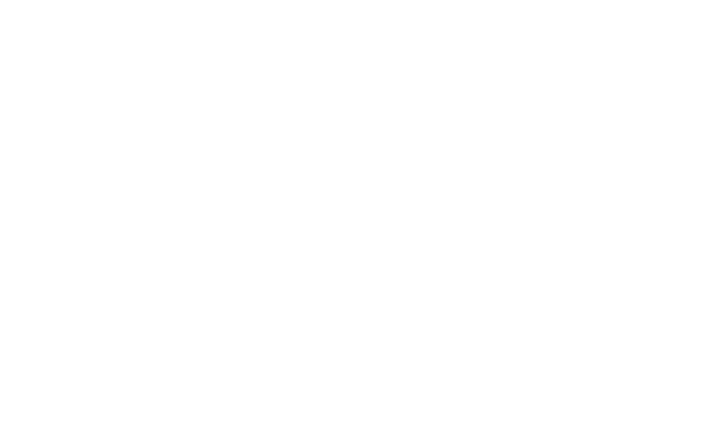

In [ ]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))


draw_tree(final_model.estimators_[0], X_train, precision=3)

# Crypto Direction

In [ ]:
df_col = pd.concat([X_val['close'],rf_prediction_values], axis=1)
df_col

,close,Precio de Cierre Real,Precio de Cierre Previsto
timestamp,,,
12/9/2019,7400.899414,7400.899414,7406.173814
12/10/2019,7278.119629,7278.119629,7270.896503
12/11/2019,7217.427246,7217.427246,7219.364798
12/12/2019,7243.134277,7243.134277,7256.376328
12/13/2019,7269.684570,7269.684570,7269.260276
...,...,...,...
4/12/2020,6971.091797,6971.091797,6971.108323
4/13/2020,6845.037598,6845.037598,6847.139023
4/14/2020,6842.427734,6842.427734,6846.490315
